# Earthquake

SEOYEON CHOI  
11/24/22

Real analysis

## imports

In [6]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go

In [7]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

## load data and clean it

`-` load

In [8]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

In [9]:
df_korea= pd.read_csv('earthquake_korea2.csv').iloc[:,[1,2,5,6]].rename(columns={'규모':'Magnitude'})

https://www.weather.go.kr/w/eqk-vol/search/korea.do?schOption=&xls=0&startTm=2012-01-02&endTm=2022-06-17&startSize=2&endSize=&startLat=&endLat=&startLon=&endLon=&lat=&lon=&dist=&keyword=&dpType=m

In [10]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

https://www.usgs.gov/programs/earthquake-hazards/lists-maps-and-statistics

`-` cleaning

In [11]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

In [12]:
df.iloc[3378,0] = '02/03/1975'

In [13]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

In [14]:
df.iloc[7512,0] = '04/28/1985'

In [15]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

In [16]:
df.iloc[20650,0] = '03/13/2011'

In [17]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

In [18]:
df.Year = df.Year.astype(np.float64)

In [19]:
df_korea = df_korea.assign(Year=list(map(lambda x: x.split('/')[0], df_korea.발생시각))).iloc[:,1:]
df_korea = df_korea.assign(Latitude=list(map(lambda x: x.split(' ')[0], df_korea.위도))).iloc[:,[0,2,3,4]]
df_korea = df_korea.assign(Longitude=list(map(lambda x: x.split(' ')[0], df_korea.경도))).iloc[:,[0,2,3,4]]

In [20]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [21]:
df_korea.Year = df_korea.Year.astype(np.float64)
df_korea.Latitude = df_korea.Latitude.astype(np.float64)
df_korea.Longitude = df_korea.Longitude.astype(np.float64)
df_global.Year = df_global.Year.astype(np.float64)

## define class

In [22]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.4,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.6
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visf(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visfhat(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='MagnitudeHat', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visres(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z=[0] * len(self.df), 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.7
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [23]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)
        #plt.plot(self.f,'.')
        #plt.plot(self.fhat,'x')

#         fig, axs = plt.subplots(2,2,figsize=(16,10))

#         axs[0,0].plot(self.f,'b')
#         axs[0,0].set_title('Magnitude')
#         axs[0,0].set_ylim([4.5,9])

#         axs[0,1].plot(self.fhat,'k')
#         axs[0,1].set_title('MagnitudeHat')
#         axs[0,1].set_ylim([4.5,9])

#         axs[1,0].plot(self.con,'r*')
#         axs[1,0].set_title('Residual square')

#         axs[1,1].plot(self.f,'b')
#         axs[1,1].plot(self.fhat,'k')
#         axs[1,1].plot(self.con,'r*')
#         axs[1,1].set_title('Graph')
#         axs[1,1].set_ylim([4.5,9])

#         plt.tight_layout()
#         plt.show()

In [24]:
class MooYaHo3(MooYaHo2):
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=126), 
                        zoom=5.7,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.5
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [25]:
       ebayesthresh = importr('EbayesThresh').ebayesthresh

## analysis_df_global(2010\~2015)

`-` make instance for analysis

In [32]:
moo_global=MooYaHo2(df_global.query("2010 <= Year < 2015"))

`-` get distance

In [33]:
moo_global.get_distance()

100%|██████████| 10762/10762 [05:32<00:00, 32.36it/s] 

In [34]:
moo_global.D[moo_global.D>0].mean()

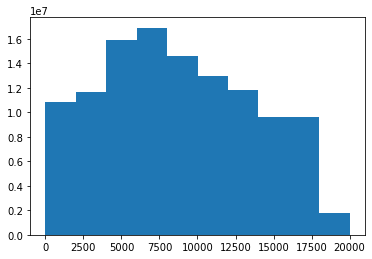

In [35]:
plt.hist(moo_global.D[moo_global.D>0])

`-` weight matrix

In [36]:
moo_global.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

In [37]:
moo_global.fit2()

In [38]:
moo_global.df.sort_values("Residual",ascending=False).iloc[:40,:]

(2010\~2014 시도) - 21번째 Ouest Department, Haiti 아이티 지진 2010년
진도 7.0 - 24번째 Puchuncavi, Valparaíso, Chile 칠레 지진 2014년 진도
6.4 - 28번째 Baoxing County, Yaan, Sichuan, China 중국 쓰촨성 지진
2013년 진도 6.6

(2010\~2015 시도_결과 좋지 않음?!) - 23번째 2010년 West New Britain
Province, Papua New Guinea 진도 7.3 - 24번째 2011년 Kuzawa Terayama,
Tanagura, Higashishirakawa District, Fukushima 963-5671, Japan 진도
6.6 - 29번째 2015년 Kishim, Afghanistan 진도 7.5

`-` vis

In [39]:
#moo_global.visf()

In [40]:
#moo_global.visfhat()

In [41]:
#moo_global.visres()

In [42]:
#moo_global.vis(MagThresh=6.9,ResThresh=0.5)

------------------------------------------------------------------------

## analysis_df_global(2015\~2020)

`-` make instance for analysis

In [43]:
moo_global=MooYaHo2(df_global.query("2015 <= Year <= 2020"))

`-` get distance

In [44]:
moo_global.get_distance()

100%|██████████| 11239/11239 [04:35<00:00, 40.84it/s] 

In [45]:
moo_global.D[moo_global.D>0].mean()

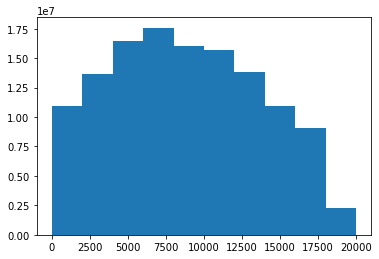

In [46]:
plt.hist(moo_global.D[moo_global.D>0])

`-` weight matrix

In [47]:
moo_global.get_weightmatrix(theta=(8814.318793468068),kappa=2500) 

`-` fit

In [48]:
moo_global.fit2()

In [49]:
moo_global.df.sort_values("Residual",ascending=False).iloc[:30,:]

바다 아닌 거 - 8번째 2016년 Rotherham, New Zealand 뉴질랜드 카이코우라
지진 진도 7.8 - 9번째 2015년 Langkuru Utara, Pureman, Alor Regency, East
Nusa Tenggara, Indonesia 수마트라 진도 6.5 - 15번째 2018년 Hela
Province, Papua New Guinea 파푸아뉴기니 진도 7.5 - 20번째 2015년
Kalinchok, Nepal 네팔 진도 7.3 - 26번째 2019년 Coquimbo, Chile 칠레
코킴보주 진도 6.7

`-` vis

In [50]:
#moo_global.vis(MagThresh=7,ResThresh=0.3)

------------------------------------------------------------------------

In [ ]:
pd.read_html('https://en.wikipedia.org/wiki/Lists_of_21st-century_earthquakes',encoding='utf-8')[0].query('Magnitude<=7')# List of deadliest earthquakes

In [ ]:
pd.read_html('https://en.wikipedia.org/wiki/Lists_of_21st-century_earthquakes',encoding='utf-8')[3] # Deadliest earthquakes by year

------------------------------------------------------------------------

In [52]:
class eachlocation(MooYaHo2):
    def haiti(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize = 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=18.4430, lon=-72.5710), 
                        zoom= adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="stamen-terrain",
                        range_color=[-3,3])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.4
                    )
                ))
        return fig 
    def lquique(self,MagThresh=7,ResThresh=1,adjzoom=5, adjmarkersize= 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=-32.6953, lon=-71.4416), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 
    def sichuan(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize=40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=30.3080, lon=102.8880), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 

In [53]:
each_location=eachlocation(df_global.query("2010 <= Year < 2015"))

`-` get distance

In [54]:
each_location.get_distance()

100%|██████████| 12498/12498 [05:55<00:00, 35.16it/s] 

In [55]:
each_location.D[each_location.D>0].mean()

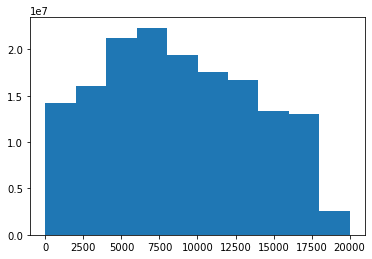

In [56]:
plt.hist(each_location.D[each_location.D>0])

`-` weight matrix

In [57]:
each_location.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

In [58]:
each_location.fit2()

In [59]:
each_location.haiti(MagThresh=6.9,ResThresh=0.5)

In [60]:
each_location.lquique(MagThresh=8,ResThresh=0.4,adjzoom=4.3)

In [61]:
each_location.sichuan(MagThresh=6.5,ResThresh=0.4)

------------------------------------------------------------------------

## 칠레

In [62]:
df_chile_ex= pd.concat([pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

In [63]:
df_chile = df_chile_ex.assign(Year=list(map(lambda x: x.split('-')[0], df_chile_ex.time))).iloc[:,1:]

In [64]:
df_chile = df_chile.assign(Month=list(map(lambda x: x.split('-')[1], df_chile_ex.time)))

In [65]:
df_chile.Year = df_chile.Year.astype(np.float64)
df_chile.Month = df_chile.Month.astype(np.float64)

In [66]:
chile_location=eachlocation(df_chile.query("2010 <= Year < 2015"))

In [67]:
chile_location.get_distance()

100%|██████████| 12498/12498 [06:28<00:00, 32.19it/s] 

In [68]:
chile_location.get_weightmatrix(theta=(chile_location.D[chile_location.D>0].mean()),kappa=2500) 

In [69]:
chile_location.fit2()

아이티

In [70]:
chile_location.df.assign(Residual2 = chile_location.df.Residual**2).reset_index().iloc[2324:2330,:]

칠레

In [71]:
chile_location.df.assign(Residual2 = chile_location.df.Residual**2).reset_index().query("-56.5 < Latitude & Latitude <-17.4 & -81.5 < Longitude & Longitude < -61.5 & Year == 2014 & Month == 8")

중국

In [72]:
chile_location.df.assign(Residual2 = chile_location.df.Residual**2).reset_index().iloc[5136:5142,:]